In [1]:
import matplotlib.pyplot as plt          #importing some packages
import numpy as np
import pandas as pd
import seaborn as sns

vgsales=pd.read_csv('Datasets/vgsales.csv', index_col=0)     #read in the csv
print(vgsales.head()) #We'll get a preliminary look at the data

                          Name Platform    Year         Genre Publisher  \
Rank                                                                      
1                   Wii Sports      Wii  2006.0        Sports  Nintendo   
2            Super Mario Bros.      NES  1985.0      Platform  Nintendo   
3               Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
4            Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
5     Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

      NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
Rank                                                           
1        41.49     29.02      3.77         8.46         82.74  
2        29.08      3.58      6.81         0.77         40.24  
3        15.85     12.88      3.79         3.31         35.82  
4        15.75     11.01      3.28         2.96         33.00  
5        11.27      8.89     10.22         1.00         31.37  


Wii Sports is more than double in global sales than the next highest entry.
Fun fact, this is due to the fact that Wii Sports came with almost every Wii sold and the Wii is one of the greatest selling 
game consoles of all time, beat out only by the Playstation and Playstation 2 (not counting handhelds).So with that advantage 
over the other games, I consider Wii Sports an anomaly and will remove it.

In [2]:
vgsales=vgsales[1:] #Remove the first entry of the zero-indexed DataFrame.
#Conveniently this data is ordered from highest global sales to lowest global sales.
print(vgsales.head())
print(vgsales.tail())

                          Name Platform    Year         Genre Publisher  \
Rank                                                                      
2            Super Mario Bros.      NES  1985.0      Platform  Nintendo   
3               Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
4            Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
5     Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   
6                       Tetris       GB  1989.0        Puzzle  Nintendo   

      NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
Rank                                                           
2        29.08      3.58      6.81         0.77         40.24  
3        15.85     12.88      3.79         3.31         35.82  
4        15.75     11.01      3.28         2.96         33.00  
5        11.27      8.89     10.22         1.00         31.37  
6        23.20      2.26      4.22         0.58         30.26  
                          

With the anomaly removed, let's get a first look at how the data are distributed. A histogram is a good way to get a quick look at the dataset's distribution.

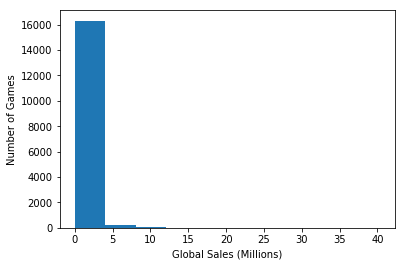

In [3]:
_=plt.hist(vgsales['Global_Sales'])
_=plt.xlabel('Global Sales (Millions)')
_=plt.ylabel('Number of Games')
plt.show()

More than 16,000 of the 16,600 games on this list sold less than 5 million copies. It may be more interesting to view the data for the more successful games. Let's look at median sales in this DF to see what we can count as successful. With so many data points an ECDF may be more appropriate to show our data's  distribution rather than a swarm plot or scatter plot. Histograms also suffer from binning bias. An ECDF will show us each point and give us a better idea of the data's distribution in a nicely visible manner.

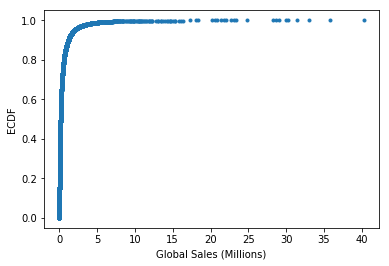

In [4]:
def ecdf(series):
    """Compute ECDF for a series of data"""
    points=len(series)
    x=np.sort(series)
    y=np.arange(1.0, points+1.0) / points
    return x, y
#This function generates x and y values which we can then plot to get our ECDF
x_global, y_global=ecdf(vgsales['Global_Sales'])
_=plt.plot(x_global, y_global, marker='.', linestyle='none')
_=plt.xlabel('Global Sales (Millions)')
_=plt.ylabel('ECDF')
plt.show()

The sales are extremely bottom heavy, with more than 80% of the data with less than 2.5 million sales. From this graph, we are presented with an idea for a hypothesis test. Let's see which genres of games have the greatest probability of being "successful". We can separate each genre into a separate DF then view their respective ECDFs to see how bottom-heavy each is. Then we can perform a hypothesis test once we decide our criteria for success in sales and determine if the difference in "success" for each genre is statistically significant.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3316 entries, 17 to 16592
Data columns (total 10 columns):
Name            3316 non-null object
Platform        3316 non-null object
Year            3253 non-null float64
Genre           3316 non-null object
Publisher       3309 non-null object
NA_Sales        3316 non-null float64
EU_Sales        3316 non-null float64
JP_Sales        3316 non-null float64
Other_Sales     3316 non-null float64
Global_Sales    3316 non-null float64
dtypes: float64(6), object(4)
memory usage: 285.0+ KB
None


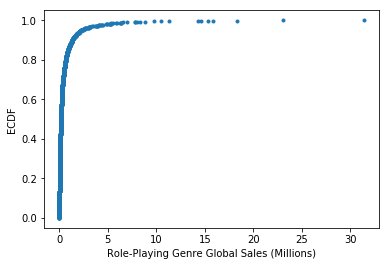

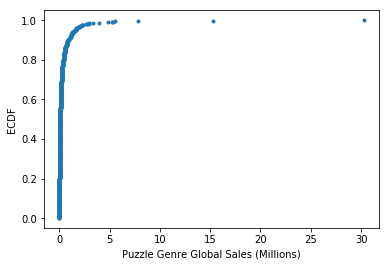

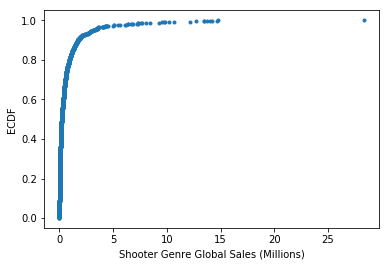

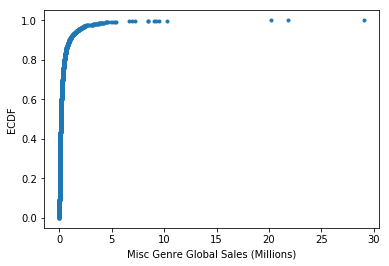

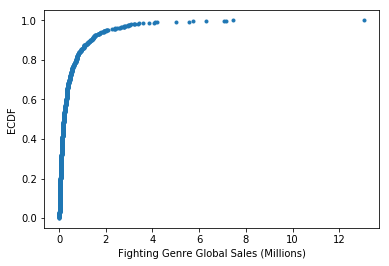

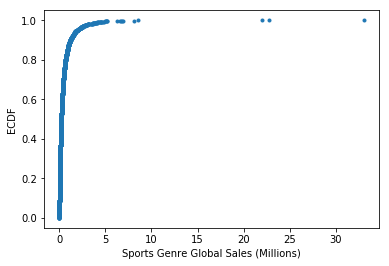

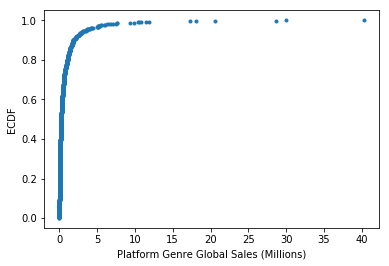

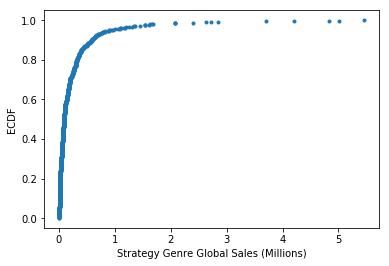

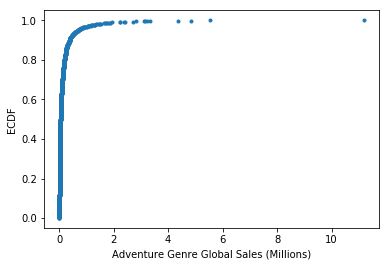

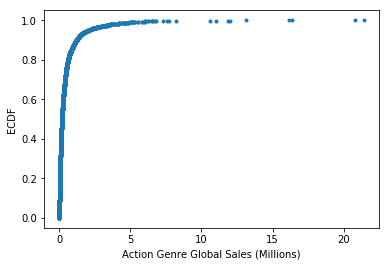

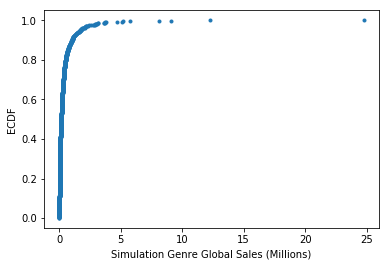

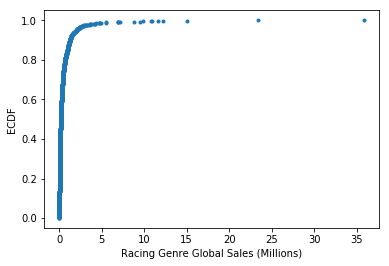

In [5]:
genre_names=vgsales['Genre'].unique().tolist() #Get a list of genres for keys for our dictionary.
genre_dict={name: vgsales.loc[vgsales['Genre']==name] for name in genre_names}  #Loop to create our dictionary of 
#genre-separated DFs
print(genre_dict['Action'].info()) #Making sure it worked.
#Now let's make a loop to create an ECDF for each genre DF.
for name in genre_dict:
    x_genre, y_genre=ecdf(genre_dict[name]['Global_Sales'])
    _=plt.plot(x_genre, y_genre, marker='.', linestyle='none')
    _=plt.xlabel(name + ' Genre Global Sales (Millions)')
    _=plt.ylabel('ECDF')
    plt.show()

At first look, the genres Shooter, Fighting, and Strategy seem to have less steep slopes on their ECDFs than the others. However, we must pay close attention to the x-axis of these plots. The Strategy genre has its first tick at 2mil and the Strategy genre has its first tick at 1mil; so even though the shape of these genres' ECDFs look less steep, they likely have a similar percentage of entries beneath our marker of success to the other genres. Let's take 1 million to be our marker of success.

In [6]:
def over_1mil(series):
    """Calculates the percentage of values over 1 million in a series where 
    values are in millions"""
    return float(len(series[series >= 1.000]))/float(len(series))*100.000
print(over_1mil(genre_dict['Action']['Global_Sales']))#Testing. It works!
#Let's loop through each genre and get a list of their over 1mil percentages
for name in genre_dict:
    percentage=over_1mil(genre_dict[name]['Global_Sales'])
    print(name + ": " + str(round(percentage, 2)) + "% of games sold over 1mil"
    + " copies out of " + str(len(genre_dict[name])) + " total games")

12.8468033776
Role-Playing: 13.64% of games sold over 1mil copies out of 1488 total games
Puzzle: 9.62% of games sold over 1mil copies out of 582 total games
Shooter: 19.24% of games sold over 1mil copies out of 1310 total games
Misc: 9.95% of games sold over 1mil copies out of 1739 total games
Fighting: 14.62% of games sold over 1mil copies out of 848 total games
Sports: 12.88% of games sold over 1mil copies out of 2345 total games
Platform: 22.01% of games sold over 1mil copies out of 886 total games
Strategy: 4.7% of games sold over 1mil copies out of 681 total games
Adventure: 3.27% of games sold over 1mil copies out of 1286 total games
Action: 12.85% of games sold over 1mil copies out of 3316 total games
Simulation: 10.73% of games sold over 1mil copies out of 867 total games
Racing: 14.57% of games sold over 1mil copies out of 1249 total games


It may be interesting to see if there is a correlation between the number of games in a genre and the percentage that sell over 1 million. To the plots!

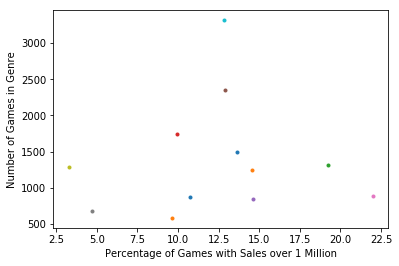

In [7]:
for name in genre_dict:
    x_perc=over_1mil(genre_dict[name]['Global_Sales'])
    y_games=len(genre_dict[name])
    _=plt.plot(x_perc, y_games, marker='.', linestyle='none')
_=plt.xlabel('Percentage of Games with Sales over 1 Million')
_=plt.ylabel('Number of Games in Genre')
plt.show()

No correlation between number of games in a genre and the percentage of games that sell over 1 million is apparent from the plots.
However, looking at the previous statements created, shooting, platforming, and fighting games are shown to be the safest genre, or, the most likely of the genres to sell over 1 million copies. Next, let's do some hypothesis testing to see how often these genres come out on top in a large number of trials testing the percentage of games that sold over 1mil with the bootstrapping method. This involves selecting an equal number of data points within each genre from the existing data points. When the first data point is randomly selected, whichever point is selected in then replaced within the dataset we are sampling from. We are sampling with replacement. This new sampled dataset is called a bootstrap sample.
First we define our bootstrap replicate function to create each individual replicate. In this case, each replicate is the percentage value from our over_1mil() function.

In [8]:
def bootstrap_rep(series, func):
    """Generate bootstrap replicate of a series"""
    bs_sample=np.random.choice(series, len(series)) #This creates a bootstrap sample.
    return(func(bs_sample)) #We use the bootstrap sample to generate our desired summary statistic, which creates the 
    #bootstrap replicate.
print(bootstrap_rep(genre_dict['Action']['Global_Sales'], over_1mil)) #it worked!

13.5102533172


Now that we have made a bootstrap replicate, we will do many trials and see how each genre is distributed with many replicates.

In [9]:
bs_replicates=np.empty(10000) #Create an empty array to store our bootstrap replicates.
bs_rep_dict={name: np.empty(10000) for name in genre_names} #Create a new dictionary to store the bs reps for each genre.
for name in genre_dict: #Loop through each genre.
    for i in range(10000): #and generate 10,000 bootstrap replicates.
        bs_rep_dict[name][i]=bootstrap_rep(genre_dict[name]['Global_Sales'], over_1mil)
print(bs_rep_dict) #it worked!

{'Role-Playing': array([13.77688172, 12.5672043 , 13.50806452, ..., 15.25537634,
       15.12096774, 12.2983871 ]), 'Puzzle': array([ 7.21649485, 11.51202749,  9.79381443, ..., 10.65292096,
       10.65292096,  8.41924399]), 'Shooter': array([18.93129771, 19.77099237, 18.24427481, ..., 18.09160305,
       18.01526718, 18.54961832]), 'Misc': array([ 9.54571593, 11.6733755 ,  9.54571593, ...,  9.60322024,
        9.94824612, 11.38585394]), 'Fighting': array([14.85849057, 14.97641509, 14.74056604, ..., 16.03773585,
       14.50471698, 15.68396226]), 'Sports': array([13.90191898, 13.64605544, 13.68869936, ..., 12.8358209 ,
       12.92110874, 13.13432836]), 'Platform': array([21.33182844, 20.20316027, 23.92776524, ..., 21.21896163,
       24.04063205, 22.00902935]), 'Strategy': array([3.81791483, 4.99265786, 3.23054332, ..., 4.6989721 , 4.25844347,
       4.6989721 ]), 'Adventure': array([3.03265941, 2.33281493, 3.11041991, ..., 3.1881804 , 3.4992224 ,
       2.87713841]), 'Action': array(

Let's take a look at the distributions for each genre. Then we can move on to ranking the top three safest genres for each replicate iteration and see which genres have the highest likelihood of success in sales.

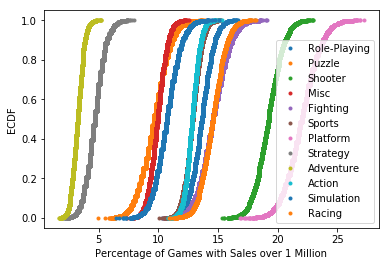

In [10]:
legend_labels=[]
for name in bs_rep_dict:
    x_bs_rep, y_bs_rep=ecdf(bs_rep_dict[name])
    _=plt.plot(x_bs_rep, y_bs_rep, marker='.', linestyle='none')
    legend_labels.append(name) #it is necessary to append the names instead of feeding a list of the labels as 
    #dictionaries do not have a specific order when called on.
    _=plt.xlabel('Percentage of Games with Sales over 1 Million')
    _=plt.ylabel('ECDF')
    _=plt.legend(legend_labels)
plt.show()

The ECDF provides some insights but something easier to digest and look at is a confidence interval. This describes a range of values of which there is a specified probability of a parameter having a value within the range. Let's calculate the 95% confidence interval (the range for which the genre is 95% likely to have an over 1 million sold percentage parameter for) for each genre.

In [11]:
percentile_dict={name: name for name in genre_names}
for name in bs_rep_dict:
    percentile_dict[name]=np.percentile(bs_rep_dict[name], [2.5, 97.5])
for name in percentile_dict:
    print(str(name)+": "+str(percentile_dict[name]))

Role-Playing: [11.96236559 15.38978495]
Puzzle: [ 7.38831615 12.02749141]
Shooter: [17.09923664 21.3740458 ]
Misc: [ 8.56814261 11.32834963]
Fighting: [12.26415094 16.98113208]
Sports: [11.5565032  14.24307036]
Platform: [19.41309255 24.83069977]
Strategy: [3.23054332 6.31424376]
Adventure: [2.33281493 4.27682737]
Action: [11.70084439 13.99276236]
Simulation: [ 8.65051903 12.80276817]
Racing: [12.6501201  16.49319456]


From this it is plain to see that Platform and then Shooter games will almost always be the safest two (Shooter, with the second highest lower end on its 95% interval, has no other genre besides Platform with an upper end of its respective 95% interval greater than its lower end value).
Let us confirm this with a hypothesis test. We will take each indice from every genre and compare them and see which genre has the highest percentagefor each iteration. We will have 10,000 winners, of which I set forth the hypothesis that 95% or greater will be Shooter or Platform.

In [12]:
#First we will set up our winner list:
bs_highest_percentage=[]
#and second and third highest percentages:
second_highest_percentage=[]
third_highest_percentage=[]
for i in range(10000): #Loop through each iteration in our bootstrapping.
    #For this loop we create another dictionary to store the bs replicate percentage value for each iteration in our 
    #10,000 trials. Then we pull thekey (genre) from the max value in the iteration. Then we delete the key:value pair 
    #with that max value and obtain the key from the new max value,giving us the key corresponding to the second highest 
    #percent value. We repeat this process to obtain the third highest value.
    bs_max={name: bs_rep_dict[name][i] for name in genre_names}
    bs_highest_percentage.append(max(bs_max, key=bs_max.get))
    bs_max.pop(bs_highest_percentage[i])
    second_highest_percentage.append(max(bs_max, key=bs_max.get))
    bs_max.pop(second_highest_percentage[i])
    third_highest_percentage.append(max(bs_max, key=bs_max.get))
print(set(bs_highest_percentage))
print(set(second_highest_percentage))
print(set(third_highest_percentage))

set(['Platform', 'Shooter'])
set(['Platform', 'Shooter', 'Racing', 'Role-Playing', 'Fighting'])
set(['Role-Playing', 'Shooter', 'Fighting', 'Simulation', 'Action', 'Sports', 'Racing'])


Through 10,000 trials only the genres Platform and Shooter had the highest percentage of games sold over 1 million.

Below is a different method I came up with to get the top 3 positions in our 10,000 trials:

"""for i in range(10000): #Loop through each iteration in our bootstrapping
    bs_max={name: bs_rep_dict[name][i] for name in genre_names}
    bs_max_list=list(bs_max.values())
    bs_max_list.sort(reverse=True)
    for genre in bs_max:
        if bs_max[genre]=bs_max_list[0]:
            bs_highest_percentage.append(bs_max, key=bs_max.get)
        if bs_max[genre]=bs_max_list[1]:
            second_highest_percentage.append(bs_max, key=bs_max.get)
        if bs_max[genre]=bs_max_list[2]:
            third_highest_percentage.append(bs_max, key=bs_max.get)"""
            
Now we will count the occurrences of each genre in each placing.

In [13]:
df_dict={"1st":bs_highest_percentage, "2nd":second_highest_percentage, "3rd":third_highest_percentage}
percentage_placing_df=pd.DataFrame(df_dict)
print(percentage_placing_df.info())
#Now lets see how many of each entry was generated in each column.
first = percentage_placing_df['1st'].value_counts()
second = percentage_placing_df['2nd'].value_counts()
third = percentage_placing_df['3rd'].value_counts()
print('')
print(first)
print('')
print(second)
print('')
print(third)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
1st    10000 non-null object
2nd    10000 non-null object
3rd    10000 non-null object
dtypes: object(3)
memory usage: 234.4+ KB
None

Platform    9431
Shooter      569
Name: 1st, dtype: int64

Shooter         9398
Platform         569
Fighting          27
Racing             5
Role-Playing       1
Name: 2nd, dtype: int64

Fighting        4566
Racing          4219
Role-Playing    1015
Sports           103
Action            59
Shooter           32
Simulation         6
Name: 3rd, dtype: int64


As hypothesized, the first placing in our trials went to Platform games ~95% of the time, with Shooter games taking the top spot the remaining ~5% and also dominates the second place ranking. No other genre got the first placing even 1 time in our 10,000 trials! Fighting and Racing games are pretty evenly represented in the third highest rank and had a small number of second place rankings each.
Let's plot and get a better visual feel for the results.

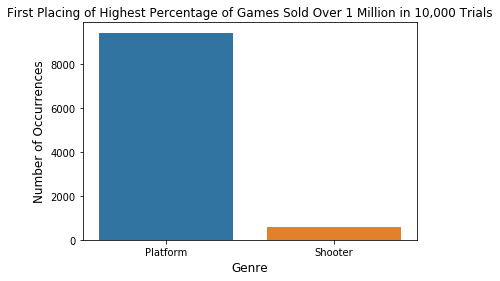

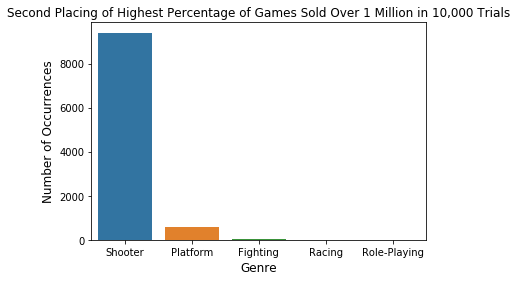

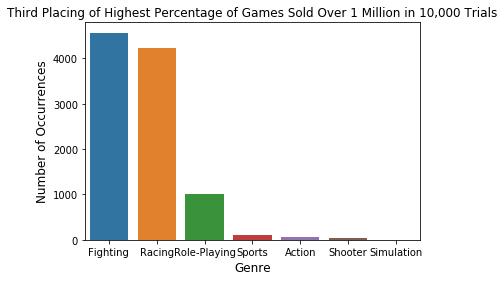

In [14]:
sns.barplot(first.index, first.values)
plt.title('First Placing of Highest Percentage of Games Sold Over 1 Million '+
          'in 10,000 Trials')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()
sns.barplot(second.index, second.values)
plt.title('Second Placing of Highest Percentage of Games Sold Over 1 Million '+
          'in 10,000 Trials')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Genre', fontsize=12) 
plt.show()
sns.barplot(third.index, third.values)
plt.title('Third Placing of Highest Percentage of Games Sold Over 1 Million '+
          'in 10,000 Trials')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()  

The plot reconfirms Platform games as the obvious choice for safest game to develop (if the goal is to sell over 1 million copies). Shooter games are a clear second safest choice with Fighting games followed closely by Racing games as the next two safest choices.
This concludes our analysis of safest games to produce by genre within the vgsales csv file.


Part 2: I am now revisiting this project to see what other insights can be gleaned from the data. 
Firstly, I am interested in how global video game sales have grown over the years. I will use the .groupby() method and filtering to quickly access this information from the dataset.

In [15]:
chrono_sales = vgsales.groupby('Year')['Global_Sales'].sum()
print(chrono_sales)

Year
1980.0     11.38
1981.0     35.77
1982.0     28.86
1983.0     16.79
1984.0     50.36
1985.0     53.94
1986.0     37.07
1987.0     21.74
1988.0     47.22
1989.0     73.45
1990.0     49.39
1991.0     32.23
1992.0     76.16
1993.0     45.98
1994.0     79.17
1995.0     88.11
1996.0    199.15
1997.0    200.98
1998.0    256.47
1999.0    251.27
2000.0    201.56
2001.0    331.47
2002.0    395.52
2003.0    357.85
2004.0    419.31
2005.0    459.94
2006.0    438.30
2007.0    611.13
2008.0    678.90
2009.0    667.30
2010.0    600.45
2011.0    515.99
2012.0    363.54
2013.0    368.11
2014.0    337.05
2015.0    264.44
2016.0     70.93
2017.0      0.05
2020.0      0.29
Name: Global_Sales, dtype: float64


Sure seems odd to have a game released in 2020 when that year hasn't begun yet. I will isolate this game and fix the year entry to be correct.

In [16]:
print(vgsales[vgsales.Year == 2020.0])

                        Name Platform    Year       Genre Publisher  NA_Sales  \
Rank                                                                            
5959  Imagine: Makeup Artist       DS  2020.0  Simulation   Ubisoft      0.27   

      EU_Sales  JP_Sales  Other_Sales  Global_Sales  
Rank                                                 
5959       0.0       0.0         0.02          0.29  


With a quick search on the internet, Imagine: Makeup Artist was released in April of 2009. Now to fix the record.

In [17]:
vgsales.loc[5959, 'Year']=2009
print(vgsales.loc[5959])

Name            Imagine: Makeup Artist
Platform                            DS
Year                              2009
Genre                       Simulation
Publisher                      Ubisoft
NA_Sales                          0.27
EU_Sales                             0
JP_Sales                             0
Other_Sales                       0.02
Global_Sales                      0.29
Name: 5959, dtype: object


Now I will plot this information. I will also see the total number of games represented in the dataset released for each year. Additionally, I will disregard the entries for 2016 and 2017 as the numbers shown make me believe the data is incomplete for those years. It could also be that certain people wait years after a game is released to buy it, waiting for a price reduction. This could explain how the sales peak for games released in 2008 then slowly taper off. Another factor could be the great recession of 2008, lowering the population's expendable income available for video game purchases.

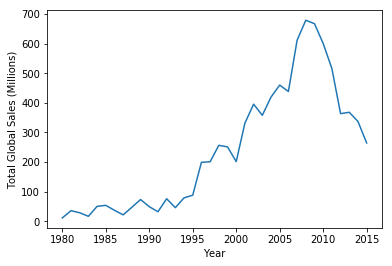

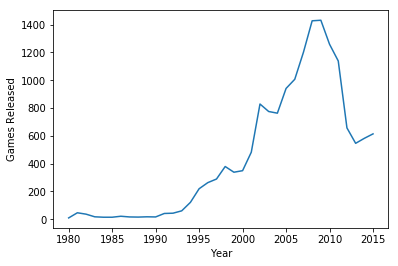

In [18]:
chrono_sales_count = vgsales.groupby('Year')['Global_Sales'].count()

_ = plt.plot(chrono_sales[:2015.0])
_ = plt.xlabel('Year')
_ = plt.ylabel('Total Global Sales (Millions)')
_ = plt.show()

_ = plt.plot(chrono_sales_count[:2015.0])
_ = plt.xlabel('Year')
_ = plt.ylabel('Games Released')
_ = plt.show()

There seems to be an extremely strong correlation between the number of games released and the number of total sales looking at the two graphs. A different insight that may be useful is how the average game sold in each year, that will make a good marker for how popular video games in general were for each year. 

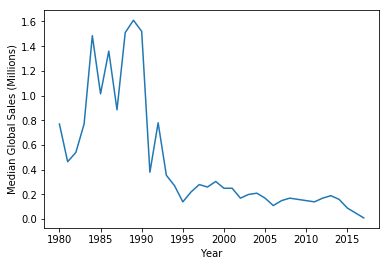

In [19]:
chrono_sales = vgsales.groupby('Year')['Global_Sales'].median()

_ = plt.plot(chrono_sales)
_ = plt.xlabel('Year')
_ = plt.ylabel('Median Global Sales (Millions)')
_ = plt.show()

It would seem from this figure that the average video game has performed significantly worse since the early 90s. I believe this to be a product of the data collected; very few games were included in this dataset from 1993 and before. Please see below:

In [20]:
print(chrono_sales_count)

Year
1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      60
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     349
2001.0     482
2002.0     829
2003.0     775
2004.0     763
2005.0     941
2006.0    1007
2007.0    1202
2008.0    1428
2009.0    1432
2010.0    1259
2011.0    1139
2012.0     657
2013.0     546
2014.0     582
2015.0     614
2016.0     344
2017.0       3
Name: Global_Sales, dtype: int64


I will likely gain more insight by only plotting years with more than 100 games represented.

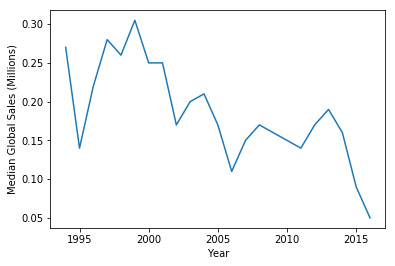

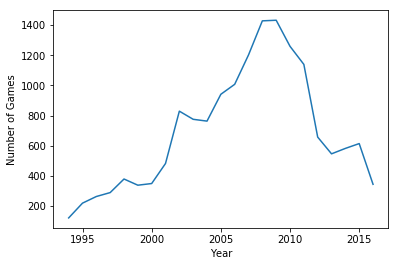

In [21]:
_ = plt.plot(chrono_sales[1994.0:2016.0])
_ = plt.xlabel('Year')
_ = plt.ylabel('Median Global Sales (Millions)')
_ = plt.show()

_ = plt.plot(chrono_sales_count[1994.0:2016.0])
_ = plt.xlabel('Year')
_ = plt.ylabel('Number of Games')
_ = plt.show()

A scatter plot of the two features will better represent any correlation to be seen.

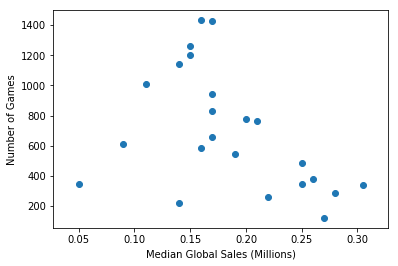

In [22]:
plt.scatter(chrono_sales[1994.0:2016.0], chrono_sales_count[1994.0:2016.0])
plt.xlabel('Median Global Sales (Millions)')
plt.ylabel('Number of Games')
plt.show()

If I exclude some outliers, there is a negative correlation between the number of games represented for the each year and the median sales of that year.

Now I will investigate which platforms have had the best performing games.

In [29]:
print(vgsales['Platform'].unique())

['NES' 'Wii' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' '3DS' 'PS4' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'GC' 'WiiU' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']


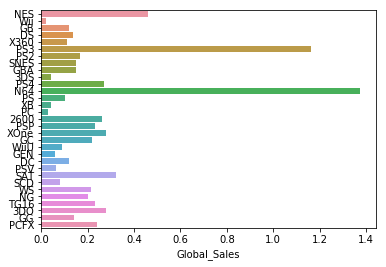

In [26]:
platform_sales = vgsales.groupby('Platform')['Global_Sales'].median()
#This is the median sales of games within each of these platforms, NOT the median sales of each platform itself.

ax = sns.barplot(x = platform_sales, y = vgsales['Platform'].unique())

I will examine the three big players of the console war: Playstation, Xbox, and Nintendo. First I will organize these DataFrames by each console. Nintendo may have a large advantage with the much higher amount of handheld systems they have released. I will therefore only be examining the home consoles, not the handhelds.

In [46]:
nintendo = vgsales.loc[vgsales['Platform'].isin(['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU'])]
xbox = vgsales.loc[vgsales['Platform'].isin(['XB', 'X360', 'XOne'])]
playstation = vgsales.loc[vgsales['Platform'].isin(['PS', 'PS2', 'PS3', 'PS4'])]
nintendo.info()
print(' ')
xbox.info()
print(' ')
playstation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2679 entries, 2 to 16597
Data columns (total 10 columns):
Name            2679 non-null object
Platform        2679 non-null object
Year            2627 non-null float64
Genre           2679 non-null object
Publisher       2678 non-null object
NA_Sales        2679 non-null float64
EU_Sales        2679 non-null float64
JP_Sales        2679 non-null float64
Other_Sales     2679 non-null float64
Global_Sales    2679 non-null float64
dtypes: float64(6), object(4)
memory usage: 230.2+ KB
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2302 entries, 16 to 16579
Data columns (total 10 columns):
Name            2302 non-null object
Platform        2302 non-null object
Year            2251 non-null float64
Genre           2302 non-null object
Publisher       2298 non-null object
NA_Sales        2302 non-null float64
EU_Sales        2302 non-null float64
JP_Sales        2302 non-null float64
Other_Sales     2302 non-null float64
Global_Sales 

First I will look at how each systems' games fared in each sales region. I predict that Xbox will do better in North America and Playstation will do better in Japan than the two respective systems will fare in other regions.

I will be summing the sales for each year in each region. The NaN values in the Nintendo and Xbox datasets will have their years reclassified as 2020.

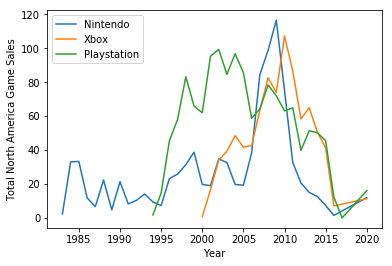

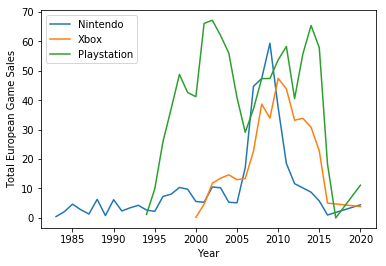

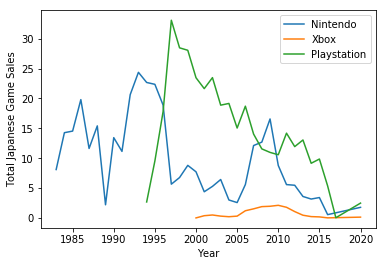

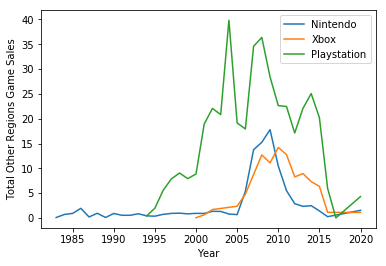

In [62]:
nintendo['Year'].fillna(2020.0, inplace = True)
xbox['Year'].fillna(2020.0, inplace = True)
playstation['Year'].fillna(2020.0, inplace = True)
nin_years = nintendo['Year'].unique().tolist()
nin_years.sort()
xbox_years = xbox['Year'].unique().tolist()
xbox_years.sort()
ps_years = playstation['Year'].unique().tolist()
ps_years.sort()

_ = plt.plot(nin_years, nintendo.groupby('Year')['NA_Sales'].sum())
_ = plt.plot(xbox_years, xbox.groupby('Year')['NA_Sales'].sum())
_ = plt.plot(ps_years, playstation.groupby('Year')['NA_Sales'].sum())
_ = plt.xlabel('Year')
_ = plt.ylabel('Total North America Game Sales')
_ = plt.legend(['Nintendo', 'Xbox', 'Playstation'])
plt.show()

_ = plt.plot(nin_years, nintendo.groupby('Year')['EU_Sales'].sum())
_ = plt.plot(xbox_years, xbox.groupby('Year')['EU_Sales'].sum())
_ = plt.plot(ps_years, playstation.groupby('Year')['EU_Sales'].sum())
_ = plt.xlabel('Year')
_ = plt.ylabel('Total European Game Sales')
_ = plt.legend(['Nintendo', 'Xbox', 'Playstation'])
plt.show()

_ = plt.plot(nin_years, nintendo.groupby('Year')['JP_Sales'].sum())
_ = plt.plot(xbox_years, xbox.groupby('Year')['JP_Sales'].sum())
_ = plt.plot(ps_years, playstation.groupby('Year')['JP_Sales'].sum())
_ = plt.xlabel('Year')
_ = plt.ylabel('Total Japanese Game Sales')
_ = plt.legend(['Nintendo', 'Xbox', 'Playstation'])
plt.show()

_ = plt.plot(nin_years, nintendo.groupby('Year')['Other_Sales'].sum())
_ = plt.plot(xbox_years, xbox.groupby('Year')['Other_Sales'].sum())
_ = plt.plot(ps_years, playstation.groupby('Year')['Other_Sales'].sum())
_ = plt.xlabel('Year')
_ = plt.ylabel('Total Other Regions Game Sales')
_ = plt.legend(['Nintendo', 'Xbox', 'Playstation'])
plt.show()

As predicted, Xbox only performed best out of the systems in North America, although that was only the case from 2010 to 2014. Also as predicted, Playstation performed best in the Japan region, rising up around 1997 and dominating Japan for almost every year until 2017.